In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 

In [3]:
import os
from glob import glob
import itertools
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
import xgboost as xgb
import matplotlib
from scipy.optimize import lsq_linear
from scipy import stats
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import pickle

## Configuration

### Plotting styling

In [4]:
colors = {}
colors['Threshold0'] = 'black'
colors['Threshold'] = 'black'
colors['Mixedbcstc'] = 'black'
colors['AutoEncoderTelescopeMSE'] = 'tab:blue'
colors['AutoEncoderStride'] = 'tab:orange'
colors['AutoEncoderQKerasTTbar'] = 'tab:red'
colors['AutoEncoderQKerasEle'] = 'tab:green'


styles = {}
styles['Threshold0'] = '-'
styles['Threshold'] = '-.'
styles['Mixedbcstc'] = '--'
styles['AutoEncoderTelescopeMSE'] = '-'
styles['AutoEncoderStride'] = '-'
styles['AutoEncoderQKerasTTbar'] = '--'
styles['AutoEncoderQKerasEle'] = '--'

markers = {}
markers['Threshold0'] = 'o'
markers['Threshold'] = 'o'
markers['Mixedbcstc'] = 'o'
markers['AutoEncoderTelescopeMSE'] = 'o'
markers['AutoEncoderStride'] = 'o'
markers['AutoEncoderQKerasTTbar'] = 'o'
markers['AutoEncoderQKerasEle'] = 'o'



legends = {}
legends['Threshold0'] = 'All TC'
legends['Threshold'] = 'Threshold 1.35 mipT'
legends['Mixedbcstc'] = 'BC+STC'
legends['AutoEncoderTelescopeMSE'] = 'AE Telescope MSE'
legends['AutoEncoderStride'] = 'AE Stride'
legends['AutoEncoderQKerasTTbar'] = 'AE QKeras ttbar'
legends['AutoEncoderQKerasEle'] = 'AE QKeras Ele'

ref_name = 'Threshold0'
plotted_algo = ['Threshold0',
                'Threshold',
                'Mixedbcstc',
                'AutoEncoderTelescopeMSE', 
                'AutoEncoderStride',
                'AutoEncoderQKerasTTbar',
                'AutoEncoderQKerasEle',
               ]

### Input files and FE algorithms to be studied
Using 200PU electron gun

In [5]:
version = '210430'
fig_dir = '../img/electron_photon_calib_autoencoder_{}'.format(version)
algo_files = {}
# Read  first set
directory = '/home/llr/cms/sauvan/DATA_UPG/HGCAL/Dataframes/study_autoencoder/3_22_1/electron_photon_signaldriven/v_1_2021-05-25'
fes = ['Threshold0', 'Threshold', 'Mixedbcstc',
       'AutoEncoderTelescopeMSE', 'AutoEncoderStride',
       'AutoEncoderQKerasTTbar', 'AutoEncoderQKerasEle',]

for fe in fes:
    algo_files[fe] = glob(directory+'/electrons/*.hdf5')


## Loading and preprocessing dataframes

In [6]:
algos_dfs = {}
for fe,files in algo_files.items():
    name = fe
    dfs = []
    for file in files:
        store = pd.HDFStore(file, mode='r')
        dfs.append(store[name])
        store.close()
    algos_dfs[fe] = pd.concat(dfs)

Selection cuts:
- Gen particle $p_T > 5GeV$
- Gen particle eta between 1.6 and 2.9

In [7]:
ptcut=5
etamin=1.6
etamax=2.9
algo_cut={}
algo_unmatch={}
for name,df in algos_dfs.items():
    sel = df['genpart_pt']>ptcut
    algo_cut[name] = df[sel]
    sel = np.abs(algo_cut[name]['genpart_exeta'])>etamin
    algo_cut[name] = algo_cut[name][sel]
    sel = np.abs(algo_cut[name]['genpart_exeta'])<etamax
    algo_cut[name] = algo_cut[name][sel]
    sel = algo_cut[name]['matches']==False
    algo_unmatch[name] = algo_cut[name][sel]
    sel = algo_cut[name]['matches']==True
    algo_cut[name] = algo_cut[name][sel]
    #algo_cut[name].dropna(inplace=True)
    algo_cut[name]['genpart_pid'].replace([-11,11],1, inplace=True)
    algo_unmatch[name]['genpart_pid'].replace([-11,11],1, inplace=True)
    algo_unmatch[name].fillna(0, inplace=True)

Retrieving energy corrections and ID BDT, and extract 99% signal efficiency cut

In [8]:
# Calib data
with open('/home/llr/cms/sauvan/Projects/L1CalorimeterTrigger_Phase2HGCal/Studies/HGCTPGBackendStudies/data/layer_weights_photons_autoencoder_{}.pkl'.format(version), 'rb') as f:
    layer_weights = pickle.load(f)
with open('/home/llr/cms/sauvan/Projects/L1CalorimeterTrigger_Phase2HGCal/Studies/HGCTPGBackendStudies/data/lineareta_electrons_autoencoder_{}.pkl'.format(version), 'rb') as f:
    calibration_eta = pickle.load(f)
    
# ID data PU discri
with open('/home/llr/cms/sauvan/Projects/L1CalorimeterTrigger_Phase2HGCal/Studies/HGCTPGBackendStudies/data/xgboost_electron_pu_autoencoder_{}.pkl'.format(version), 'rb') as f:
    boosters = pickle.load(f)
bdts = boosters['extended']

# ROC curves
with open('/home/llr/cms/sauvan/Projects/L1CalorimeterTrigger_Phase2HGCal/Studies/HGCTPGBackendStudies/data/xgboost_threshold_electron_pu_autoencoder_{}.pkl'.format(version), 'rb') as f:
    thresholds = pickle.load(f)
with open('/home/llr/cms/sauvan/Projects/L1CalorimeterTrigger_Phase2HGCal/Studies/HGCTPGBackendStudies/data/xgboost_tpr_electron_pu_autoencoder_{}.pkl'.format(version), 'rb') as f:
    tprs = pickle.load(f)
    
# Extract working point
wp = 0.99
working_points = {}
for name in algo_cut.keys():
    working_points[name] = np.interp(wp, tprs['extended'][name], thresholds['extended'][name])

Apply energy corrections and BDT, and select clusters passing working point.

Keep track of the unmatched electrons; the efficiency computed later is the total efficiency (reconstruction + matching + ID).

In [9]:
for name,df in algo_cut.items():
    print(name)
    df['cl3d_abseta'] = np.abs(df.cl3d_eta)
    layers = np.array(df['cl3d_layer_pt'].tolist())[:,2:15]
    df['cl3d_pt_calib'] = np.dot(layers, layer_weights[name])
    df['cl3d_pu_corr'] = calibration_eta[name].predict(df[['cl3d_abseta']])
    df['cl3d_pt_corr'] = df.cl3d_pu_corr + df.cl3d_pt_calib
    feature_names = bdts[name].feature_names
    matrix = xgb.DMatrix(data=df[feature_names], feature_names=feature_names)
    df['cl3d_bdt_id'] = bdts[name].predict(matrix)
    df['cl3d_bdt_pass'] = df['cl3d_bdt_id'] > working_points[name]

for name,df in algo_unmatch.items():
    df['cl3d_abseta'] = np.abs(df.cl3d_eta)
    df['cl3d_pt_calib'] = 0
    df['cl3d_pu_corr'] = 0
    df['cl3d_pt_corr'] = 0
    df['cl3d_bdt_id'] = 0
    df['cl3d_bdt_pass'] = False

algo_match_unmatch={}
for name,df in algo_cut.items():
    algo_match_unmatch[name] = pd.concat([df, algo_unmatch[name]])

Threshold0
Threshold
Mixedbcstc
AutoEncoderTelescopeMSE
AutoEncoderStride
AutoEncoderQKerasTTbar
AutoEncoderQKerasEle


## Computing turnons

In [10]:
for name,df in algo_match_unmatch.items():
    df['genpart_binpt'] = ((df.genpart_pt - ptcut)/1).astype('int32')

In [11]:
def efficiency(group, idvar, threshold):
    tot = group.shape[0]
    sel = group[group[idvar] & (group.cl3d_pt_corr>threshold)].shape[0]
    return sel/tot

Efficiency is binned in fine 1 GeV bins and smoothened with a triangular kernel on a 5 bin window.

In [12]:
turnon_thresholds = range(5, 85, 1)
efficiencies_vs_pt = {}
for name,df in algo_match_unmatch.items():
    print(name)
    efficiencies_vs_pt[name] = df.groupby('genpart_binpt').mean()
    for threshold in turnon_thresholds:
        eff = df.groupby('genpart_binpt').apply(lambda x : efficiency(x, 'cl3d_bdt_pass', threshold))
        eff_smooth = eff.rolling(window=5, win_type='triang', center=True).mean()
        efficiencies_vs_pt[name]['efficiency_{}'.format(threshold)] = eff
        efficiencies_vs_pt[name]['efficiency_smooth_{}'.format(threshold)] = eff_smooth

Threshold0
Threshold
Mixedbcstc
AutoEncoderTelescopeMSE
AutoEncoderStride
AutoEncoderQKerasTTbar
AutoEncoderQKerasEle


Plot turnon curves for different L1 threshold, for Threshold0 option

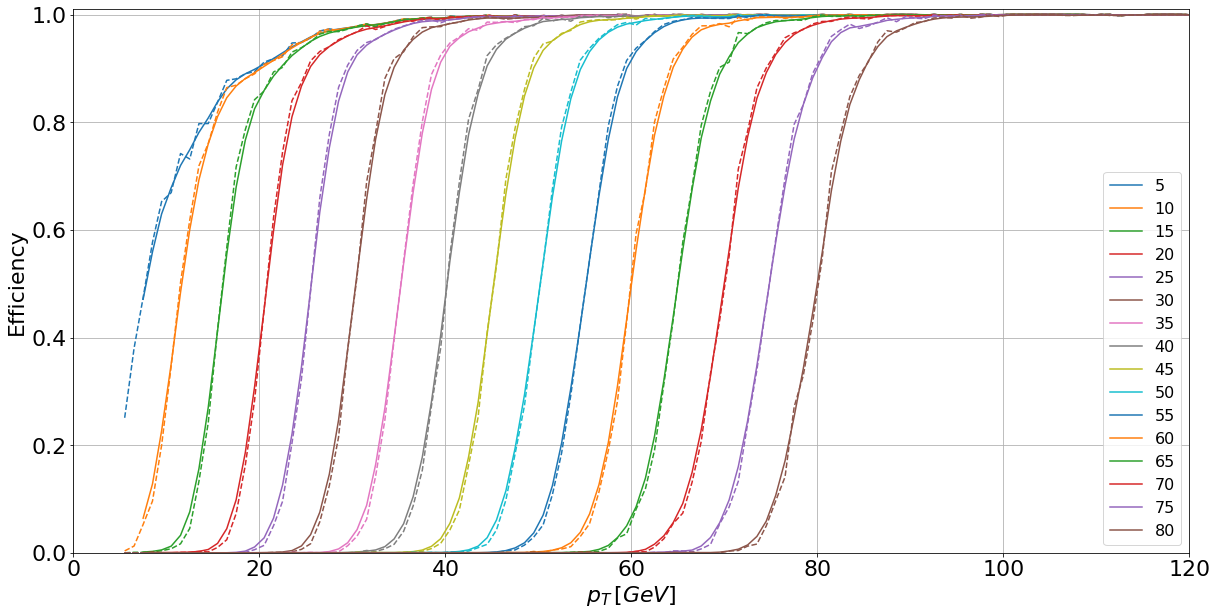

In [13]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
df = efficiencies_vs_pt['Threshold0']
for threshold in range(5, 85, 5):
    eff = df['efficiency_{}'.format(threshold)]
    eff_smooth = df['efficiency_smooth_{}'.format(threshold)]
    line, = plt.plot(df.genpart_pt, eff_smooth, label=threshold, ls='-')
    plt.plot(df.genpart_pt, eff, color=line.get_color(), ls='--')
plt.ylim(0., 1.01)
plt.xlim(0., 120)
plt.legend(loc = 'lower right', fontsize=16)
plt.xlabel(r'$p_{T}\,[GeV]$')
plt.ylabel('Efficiency')
plt.grid()
plt.show()

Compare turnons of the different FE algorithms for a L1 threshold of 30 GeV

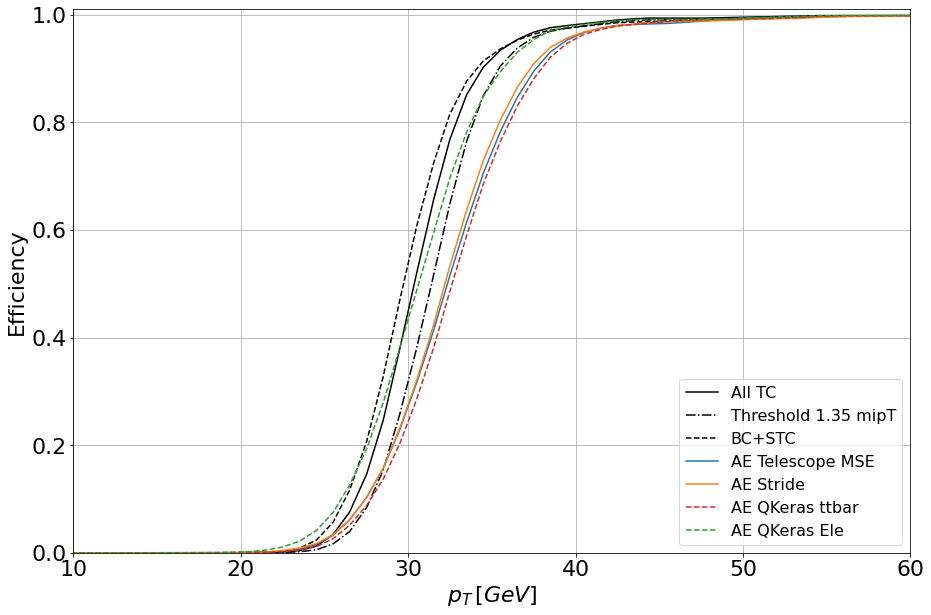

In [14]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(15,10))
threshold = 30
for name in plotted_algo:
    df = efficiencies_vs_pt[name]
    eff_smooth = df['efficiency_smooth_{}'.format(threshold)]
    plt.plot(df.genpart_pt, eff_smooth, color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 1.01)
plt.legend(loc = 'lower right', fontsize=16)
plt.xlabel(r'$p_{T}\,[GeV]$')
plt.ylabel('Efficiency')
plt.xlim(10, 60)
plt.grid()
plt.show()

## Extracting the L1 $\to$ offline threshold mapping
Extract the 95% efficiency points of the turnons.

In [15]:

pt_95s = {}
for name, df in efficiencies_vs_pt.items():
    mapping = {'threshold':[], 'pt95':[]}
    for threshold in range(5, 80, 1):
        eff_smooth = df['efficiency_smooth_{}'.format(threshold)]
        pt_95 = np.interp(0.95, eff_smooth, df.genpart_pt)
        mapping['threshold'].append(threshold)
        mapping['pt95'].append(pt_95)
    pt_95s[name] = pd.DataFrame(mapping)

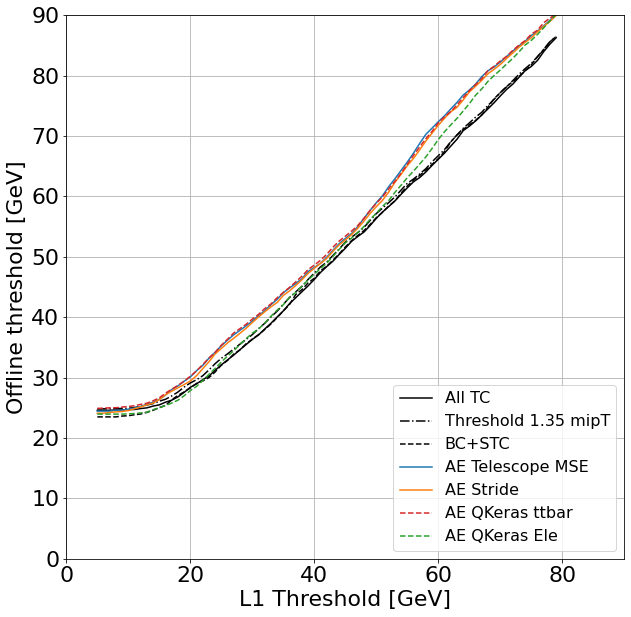

In [16]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,10))
for name in plotted_algo:
    df = pt_95s[name]
    plt.plot(df.threshold, df.pt95, color=colors[name], ls=styles[name], label=legends[name])
plt.legend(loc = 'lower right', fontsize=16)
plt.xlabel('L1 Threshold [GeV]')
plt.ylabel('Offline threshold [GeV]')
plt.xlim(0, 90)
plt.ylim(0, 90)
plt.grid()
plt.show()

## Store the L1 $\to$ offline mappings for external use

In [17]:
with open('../data/mapping_threshold_95eff_autoencoder_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(pt_95s, f)